---
title: 'F-in' statistic
---

I recently read this passage in the section on multiple linear regression from the fantastic book [Introduction to Statistical Learning](https://link.springer.com/chapter/10.1007/978-1-4614-7138-7_3#Sec7):

>The hypothesis test is performed by computing the *F-statistic*,

$$ F = \frac{(TSS - RSS)/p}{(RSS)/(n-p-1)} $$

>where, as with simple linear regression, TSS = $\Sigma(y_i - \bar{y_i})^2$ and RSS = $\Sigma(y_i - \hat{y_i})^2$. ... When there's no relationship between the response and predictors, one would expect the F-statistic to take on a value close to 1.

I then thought to myself, "Wait, why is the F-statistic appearing here? I came across the F-statistic in the [Khan Academy lesson on ANOVA](https://www.khanacademy.org/math/statistics-probability/analysis-of-variance-anova-library)."

In a span of 5 seconds, my mind made zipped around to a few places including to a conversation I had with Insight fellows and re-thinking the F-statistic calculation statistic on ANOVA and then I had a [whoa](https://media.giphy.com/media/uPnKU86sFa2fm/giphy.gif) moment: the F-statistic in multiple linear regression and in ANOVA are the same thing.

Let's investigate!

## Evaluate using a small dataset

The f-statistic is used most often when testing for differences in means for more than two groups, but let's start simple with two groups with four datapoints in each group to better comprehend what's going on.

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm

In [131]:
df_2f = pd.DataFrame()
df_2f['A'] = [2,1,3,0]
df_2f['B'] = [5,3,4,6]
df_2f

,A,B
0,2,5
1,1,3
2,3,4
3,0,6


### Using one-way ANOVA to calculate the F-statistic

Let's apply the traditional one-way ANOVA formulas towards get the F-statistic. 

$$ F = \frac{(SSB)/(m-1)}{(SSW)/(m*(n-1)} = \frac{(SST-SSW)/(m-1)}{(SSW)/(m*(n-1)} $$

where SSB = sum of squares between groups and SSW is sum of squares within groups. SST = sum of squares total and is simply the sum of SSB and SSW hence the substitution in the right-most equation. 
The number of groups is represented by *m* (2 in this example) and *n* is the number of samples in each group (4). The formula will be further defined and below.

First, we need to start out by finding the means for each group.

In [51]:
n = df_2f.shape[0]
m = df_2f.shape[1]
print('n:', n, 'and', 'm:', m)

n: 4 and m: 2


In [52]:
print('Means of each group: ')
print(df_2f.mean())

Means of each group: 
A    1.5
B    4.5
dtype: float64


We also need to calculate the `grand mean` also known as the mean across all samples regardless of group.

In [27]:
grand_mean = df_2f.mean().mean()
print(grand_mean)

3.0


Now we have the components to get SSW and SSB in just a few lines but I will point out parts of the calculations that are important. Here is how we can get SSW.

In [28]:
ssw = ((df_2f - df_2f.mean())**2).sum().sum()
ssw

10.0

This snippet is getting the difference of each value from it's *own group's mean*. That is why it is called "sum of squares within."

In [32]:
(df_2f - df_2f.mean())

,A,B
0,0.5,0.5
1,-0.5,-1.5
2,1.5,-0.5
3,-1.5,1.5


Here is how we can get SST.

In [35]:
sst = ((df_2f - grand_mean)**2).sum().sum()
print(sst)

28.0


This snippet is getting the difference of each value from the *grand mean*. The resulting value of SST is entirely group independent and is representative of the total variation of the data, hence the "sum of squares total".

In [34]:
(df_2f - grand_mean)

,A,B
0,-1.0,2.0
1,-2.0,0.0
2,0.0,1.0
3,-3.0,3.0


As noted above, SSB is the difference of SST and SSW.

In [36]:
ssb = sst-ssw
print(ssb)

18.0


It is a little less intuitive to understand the variation it is capturing this way. The alternative calculation is to *substitute* each data point by its own group mean before taking the difference from the grand mean.

In [56]:
df_2f_grpmean = pd.concat([df_2f.mean()]*n, axis=1).T
df_2f_grpmean

,A,B
0,1.5,4.5
1,1.5,4.5
2,1.5,4.5
3,1.5,4.5


You can see that we get the same value for SSB when calculating this way.

In [58]:
ssb_alt = ((df_2f_grpmean - grand_mean)**2).sum().sum()
ssb_alt

18.0

Now we can just plug in the values from the formula to get the F-statistic.

In [177]:
f_stat_anova = (ssb/(m-1)) / (ssw/(m*(n-1)))
print('F-statistic from ANOVA: {0:0.4f}'.format(f_stat_anova))

F-statistic from ANOVA: 10.8000


Exciting! We have an answer. Now let's move on to the regression setting. Will we get the same answer? Read on!

## Using regression to get the f-statistic

As noted in the intro, the context where the f-statistic shows up in ISLR is in the section on linear regression, specifically multiple linear regression. The null hypothesis is that all $\beta$ coefficients are equal to zero. This means we have to do some finagling with our dataset to address the question. We're going to set the dataset in our values as our target and address group membership through dummy features like this. 

In [129]:
df_2f_reg = pd.DataFrame()
df_2f_reg['y'] = np.array(df_2f.T.values).flatten()
df_2f_reg['dummyA'] = [1,1,1,1,0,0,0,0]
df_2f_reg['dummyB'] = [0,0,0,0,1,1,1,1]
df_2f_reg

,y,dummyA,dummyB
0,2,1,0
1,1,1,0
2,3,1,0
3,0,1,0
4,5,0,1
5,3,0,1
6,4,0,1
7,6,0,1


What is going on here? It might help to look at the equations that each line represents. Let's just look at the first four rows, which all contain a 1 for the dummyA value and 0 for the dummyB value.

$ 2 = \beta_0 + \beta_1 \times 1 + \beta_2 \times 0 $
<br>
$ 1 = \beta_0 + \beta_1 \times 1 + \beta_2 \times 0 $
<br>
$ 3 = \beta_0 + \beta_1 \times 1 + \beta_2 \times 0 $
<br>
$ 0 = \beta_0 + \beta_1 \times 1 + \beta_2 \times 0 $

This can be simplified to:
<br>
$ 2 = \beta_0 + \beta_1$
<br>
$ 1 = \beta_0 + \beta_1$
<br>
$ 3 = \beta_0 + \beta_1$
<br>
$ 0 = \beta_0 + \beta_1$

And if you were to solve for this equation, check out what the left-side simplifies to:
<br>
$ 1.5 = \beta_0 + \beta_1 $

The left-hand side of the equation is the mean of the group A in the ANOVA case!

We can apply the same logic to the set of equations where a 1 is assigned for the dummyA value and 0 for the dummyB value.
<br>
$ 5 = \beta_0 + \beta_2$
<br>
$ 3 = \beta_0 + \beta_2$
<br>
$ 4 = \beta_0 + \beta_2$
<br>
$ 6 = \beta_0 + \beta_2$

We are left with:
<br>
$ 4.5 = \beta_0 + \beta_2 $

4.5 is the mean of the group B in the ANOVA case! [Don't act like you're not impressed!](https://makeameme.org/meme/dont-act-like-5dx76t) 

OK let's geek out a little bit more and see if we can tie that back into the formula that uses total sum of squares (TSS) and residual sum of squares (RSS). From above, we have:

$$ F = \frac{(TSS - RSS)/p}{(RSS)/(n-p-1)} $$

and $ TSS = \Sigma(y_i - \bar{y_i})^2$ and $ RSS = \Sigma(y_i - \hat{y_i})^2$. Note that the right-side of these equations almost look the same but one contains "y bar" (the average of all y values) and the other contains "y hat" (the value predicted by the model). Let's start with TSS!

TSS is the sum of the squared difference of the values from $\bar{y}$. To be clear, $\bar{y}$ is the average of all values regardless of its associated dummy variable group. If you read the ANOVA section, this sounds a lot like the grand mean! And it doesn't take a neurosurgeon to figure out that SST (sum of squares total) and TSS (total sum of squares) are basically the same thing just in different contexts.

In [133]:
y_bar = df_2f_reg['y'].mean()
tss = 0
for i in range(len(df_2f_reg['y'])):
    tss += (df_2f_reg['y'][i]-y_bar)**2
print('TSS: ', tss)    

TSS:  28.0


Tying the residual sum of squares (RSS) to the traditional ANOVA calculation is a little less obvious. RSS is the sum of the squared difference of the values from $\hat{y}$ and for this we need the coefficient values. Let's use `statsmodels` to get this.

In [164]:
# Setup the dataframe
X = df_2f_reg[["dummyA", "dummyB"]]
y = df_2f_reg["y"]
X1 = sm.add_constant(X.values)  # Vector of 1s is needed for the beta0 coefficient
# Fit the model and get the coefficients
mod = sm.OLS(endog=y, exog=X1)
res = mod.fit()
res.params

const    2.0
x1      -0.5
x2       2.5
dtype: float64

Great! Also notice how summing `const` and `x1` (representing the $\beta_0$ and $\beta_1$ coefficients, respectively) give 1.5 as we had calculated above. The sum of `const` and `x2` give 4.5 as we predicted. To calculate RSS, here's a function of how to do this using some linear algebra to simplify the coding a little bit.

In [165]:
def get_rss(betas, X_vals, y_vals):
    beta_x_matrix = betas*X_vals     # Vector x matrix to give the prediction
    res_vector = y_vals - np.sum(beta_x_matrix, axis=1)
    rss = np.sum(res_vector**2)
    return rss

In [174]:
rss = get_rss(np.array(res.params), X1, y)
print('RSS: ', rss)  

RSS:  10.0


This gives us the same value as the SSW in ANOVA! How can we think about TSS and RSS? Let's show a figure to help illustrate this.

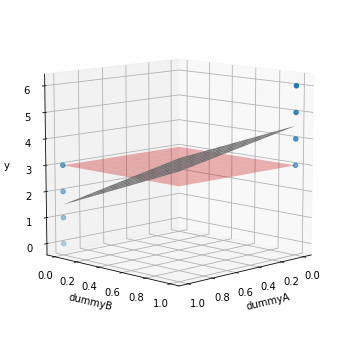

In [176]:
# xx and yy are input values I'm using for the model surface
xx = np.linspace(0,1,10)
yy = np.linspace(0,1,10)
X,Y = np.meshgrid(xx,yy)
Z = res.params[0] + res.params[1]*X + res.params[2]*Y    # Here's where the model is generating predicted values
Z_mean = np.array([[y_bar]*len(X)]*len(Y))               # Z_mean is just the average of df_2f['y']

fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, color='gray', alpha=1)          # This is plotting the model
ax.plot_surface(X, Y, Z_mean, color='red', alpha=0.3)    # This is plotting the target average (model independent)
ax.scatter(df_2f_reg['dummyA'], df_2f_reg['dummyB'], df_2f_reg['y'], marker='o')
ax.view_init(elev=10., azim=45)
ax.set_xlabel('dummyA')
ax.set_ylabel('dummyB')
ax.set_zlabel('y');

TSS is the squared sum of the distance of all datapoints to the red plane, which is the average of all values for the target. RSS is the squared sum of the distance of all values to the gray plane representing the model prediction. But since each dummy variable is essentially used to group, the model predictions are 1.5 for the datapoints encoded for group A and 4.5 for those in group B (opposite ends in the gray plane).

Okay now we're ready to get the f-statistic from the regression setting.

The ISLR formula uses "p" for the number of features. (I have to admit that I had to make an adjustment by subtracting two here to get the right answer. I believe it has to do with the degrees of freedom but I am not 100% sure. Sorry I'm not 100% confident explaining this!)

In [202]:
p = df_2f_reg.shape[1]-2   # no. of features - 2 
n = df_2f_reg.shape[0]     # no. of samples

In [203]:
f_stat_reg = ((tss-rss)/(p)) / (rss/(n-p-1))
print('F-statistic from regression: {0:0.4f}'.format(f_stat_reg))

F-statistic from regression: 10.8000


Let's see what happens if we run this through statsmodels regression model.

In [204]:
print('Statsmodels f-statistic value: {0:0.4f}'.format(res.fvalue))

Statsmodels f-statistic value: 10.8000


Well it's satisfying that the software package gives us the same f-statistic value as what we calculated in the ANOVA case.

## Conclusion

I went down this rabbit hole because I think it's great to connect theory across different settings. Doing things manually allows you to see connections about where some statistics are applicable. In addition, this can provide additional context to what numbers software packages like statsmodels can provide. Hope you learned something, because I know I have!